# Exploratory Weather Data Analysis
This analysis will use daily weather data created in [part one](#) and will focus on:

1. Quantifying the "missingness" of weather and precipitation measurements
2. Exploring relationships between weather and precipitation variables
3. Visualizing how weather and precipitation are changing over time

As this is an EDA (exploratory data analysis), emphasis will be placed on graphical rather than statisical representations of the data in the hopes (and expectation) that readers will be able to better identify better with the data through visualization than with the raw numbers.

In [130]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import itertools
warnings.filterwarnings('ignore')
%matplotlib inline

## Data

In [131]:
df = pd.read_csv('../data/processed/daily-weather-data.csv', parse_dates=['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3407 entries, 0 to 3406
Data columns (total 9 columns):
date             3407 non-null datetime64[ns]
totalPrecipMM    3361 non-null float64
minTemp          3407 non-null float64
maxTemp          3406 non-null float64
meanTemp         3406 non-null float64
totalSnowCM      1109 non-null float64
season           3407 non-null object
year             3407 non-null int64
month            3407 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 239.6+ KB
None


,date,totalPrecipMM,minTemp,maxTemp,meanTemp,totalSnowCM,season,year,month
0,2010-01-01,4.9,-9.2,0.0,-4.6,15.0,winter,2010,1
1,2010-01-02,4.1,-14.1,-9.2,-11.7,6.0,winter,2010,1
2,2010-01-03,1.1,-12.6,-5.6,-9.1,1.0,winter,2010,1
3,2010-01-04,0.5,-11.2,-7.5,-9.4,1.0,winter,2010,1
4,2010-01-05,0.0,-8.9,-3.5,-6.2,NaN,winter,2010,1


In [132]:
df['day'] = df['date'].dt.day

In [133]:
df['date'].describe()

count                    3407
unique                   3407
top       2015-10-18 00:00:00
freq                        1
first     2010-01-01 00:00:00
last      2019-04-30 00:00:00
Name: date, dtype: object

## Missing Values

Summary statistics for missing values:

In [134]:
max_missing_vars = df.isnull().sum(axis=1).sort_values(ascending=False).values[0]
max_missing_day = df.loc[df.isnull().sum(axis=1).sort_values(ascending=False).head(1).index, 'date'].values[0]
n_missing_precip = df.totalPrecipMM.isnull().sum()

print("Number of variables: %s" % len(df.columns))
print("Highest number of variables missing a value: {}".format(max_missing_vars))
print("Day with highest number of variables missing a value: %s" % pd.to_datetime(max_missing_day).date())
print("Number of days missing precipitation: {}".format(n_missing_precip))

Number of variables: 10
Highest number of variables missing a value: 4
Day with highest number of variables missing a value: 2011-10-24
Number of days missing precipitation: 46


Which months are missing the most precipitation measurements?

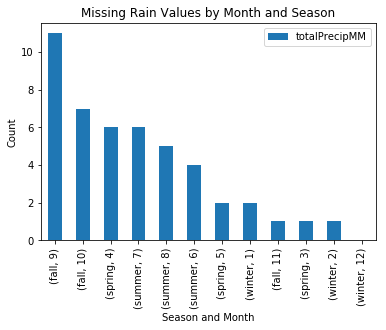

In [135]:
missing_df = df[['month', 'season', 'totalPrecipMM']].groupby(
  ['season', 'month'])[['totalPrecipMM']].apply(lambda x: pd.isnull(x).sum())
missing_df.sort_values('totalPrecipMM', ascending=False).plot(kind='bar').set(
  title='Missing Rain Values by Month and Season',
  xlabel='Season and Month',
  ylabel='Count');

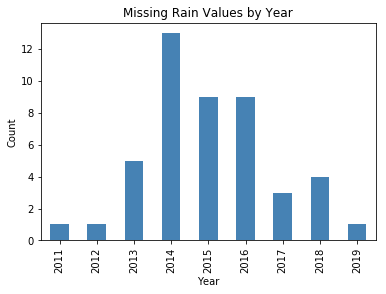

In [136]:
df[df.totalPrecipMM.isnull()].groupby(
  ['year']).size().plot(kind='bar', color='steelblue').set(
  title='Missing Rain Values by Year',
  xlabel='Year',
  ylabel='Count');

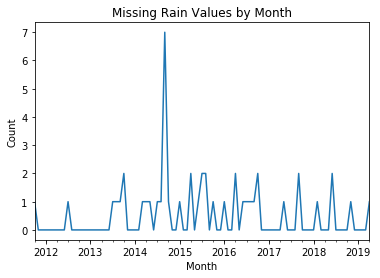

In [137]:
df[df.totalPrecipMM.isnull()].set_index('date').resample('1M').size().plot().set(
  title='Missing Rain Values by Month',
  xlabel='Month',
  ylabel='Count');

Missing precipitation readings has been reduced substationally over the last couple of years and the number of missing observations in any given month is small (generally 2 or less missing observations per month). Since we don't see the missing values having any significant impact on our analysis, we'll keep them in the dataset.

## How much rain is expected daily?

### Distribution

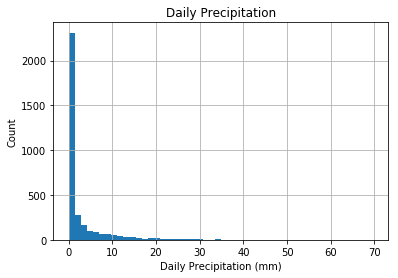

In [138]:
df.totalPrecipMM.hist(bins=50).set(
  title='Daily Precipitation',
  xlabel='Daily Precipitation (mm)',
  ylabel='Count');

Looks like there are lots of observations where $totalPrecipMM=0$ which is to be expected. What is the proportion of days with observed precipitation?

In [139]:
len(df.query('totalPrecipMM > 0')) / len(df)

0.5036689169357206

Intuitively, we wouldn't expect that it rains 50% of the time. There are likely a lot of days with trace amounts of precipitation. We can use the guidelines provided in [1] for a more meaningful definition of rain.

In [140]:
len(df.query('totalPrecipMM >= 0.2')) / len(df)

0.4769592016436748

Let's look at different parts of the distribution to understand different precipitation levels.

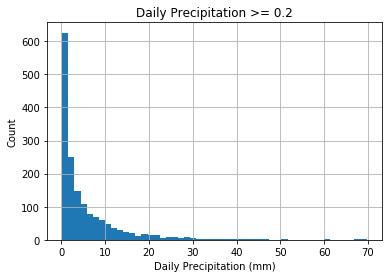

In [141]:
rainy_days = df.query('totalPrecipMM >= 0.2')
rainy_days.totalPrecipMM.hist(bins=50).set(
  title='Daily Precipitation >= 0.2',
  xlabel='Daily Precipitation (mm)',
  ylabel='Count');

In [143]:
rainy_day_stats = rainy_days['totalPrecipMM'].describe()
rainy_day_stats

count    1625.000000
mean        5.529569
std         7.645255
min         0.200000
25%         0.850000
50%         2.500000
75%         7.200000
max        69.700000
Name: totalPrecipMM, dtype: float64

As we noted in the station analysis notebook, precipitation is known to follow a gamma distribution. 

Rain intensity is defined using hourly rates [1] which is not available with daily precipitation data since rain will not be uniformly distributed over each hour in a day - simply dividing an observation by 24 would result in very low rates and only the most extreme observations (the three observations greater than 60mm) would be considered "light rain" since $\frac{60}{24}=2.5$. To compute an hourly rate we could use hourly data available from [2] for the Airport and CS stations or compute the n-index and resulting intensities as described in [3]. 

Rather than incurring the additional work, we can look more closely at the distribution of daily precipitation levels to start to classify / bucket rainfall.

#### All precipitation

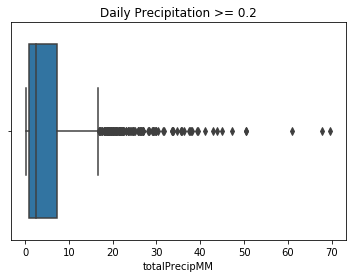

In [144]:
sns.boxplot(rainy_days['totalPrecipMM']).set(title='Daily Precipitation >= 0.2');

#### At or above the median

We'll chose to use the median because it is more interesting, for the purpose of this analysis (mean is skewed and represents the long tail).

In [145]:
median = rainy_day_stats['50%']

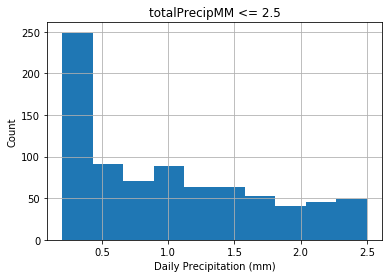

In [146]:
median_query = f'totalPrecipMM <= {median}'
median_data = rainy_days.query(median_query)

median_data['totalPrecipMM'].hist().set(
  title=median_query,
  xlabel='Daily Precipitation (mm)',
  ylabel='Count'
);

In [147]:
250 / len(rainy_days)

0.15384615384615385

Precipitation level fairly uniform over the lower range except for first bucket => rain volume is fairly unpredictable with the exception of when it does not rain "very much" (lower part of the distribution)

#### 95th percentile

In [148]:
percentile_95 = rainy_days['totalPrecipMM'].quantile(.95)
percentile_95

20.79

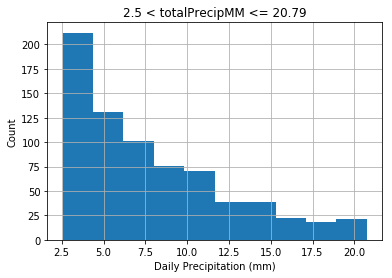

In [149]:
percentile_95_query = f'{median} < totalPrecipMM <= {percentile_95}'
percentile_95_data = rainy_days.query(percentile_95_query)

percentile_95_data['totalPrecipMM'].hist().set(
  title=percentile_95_query,
  xlabel='Daily Precipitation (mm)',
  ylabel='Count'
);

In [150]:
len(percentile_95_data) / len(rainy_days)

0.44861538461538464

Close to the same proportion of rainy days have observed precipitation of between ~2.5mm and 20mm of rain.

#### 99th percentile

In [151]:
percentile_99 = rainy_days['totalPrecipMM'].quantile(.99)
percentile_99

36.25599999999999

In [152]:
percentile_99_data = rainy_days.query(f'totalPrecipMM >= {percentile_99}')
len(percentile_99_data)

17

Rainy days with at least 30mm of precipitation is rare. When were the outliers observed?

In [153]:
percentile_99_data.groupby(['season', 'month', 'year']).size().rename('Count > 30mm').to_frame()

Count > 30mm
season month year              
fall   9     2013             3
             2014             2
       10    2013             1
       11    2011             1
spring 3     2016             1
       4     2013             1
             2017             1
       5     2013             1
summer 6     2012             1
             2015             1
       8     2011             2
             2016             1
winter 1     2013             1

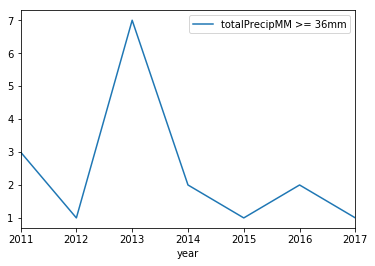

In [154]:
percentile_99_data.groupby(['year']).size().rename(f'totalPrecipMM >= {int(percentile_99)}mm').to_frame().plot();

2013 saw the most extreme precipitation events

### Remove outliers

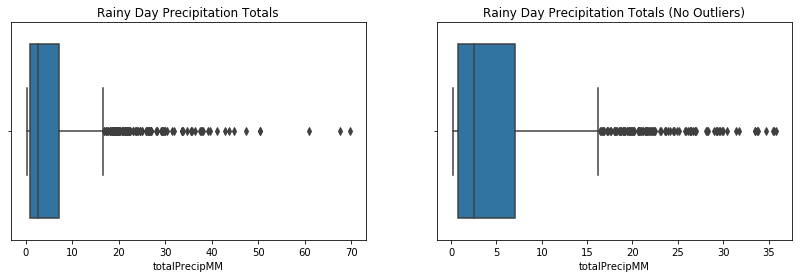

In [155]:
rainy_days_no = rainy_days[~(rainy_days.index.isin(percentile_99_data.index))]

plt.figure(figsize=(14,4))
plt.subplot(121);
sns.boxplot(rainy_days['totalPrecipMM']).set(title='Rainy Day Precipitation Totals');
plt.subplot(122);
sns.boxplot(rainy_days_no['totalPrecipMM']).set(title='Rainy Day Precipitation Totals (No Outliers)');

### By year

#### With Outliers

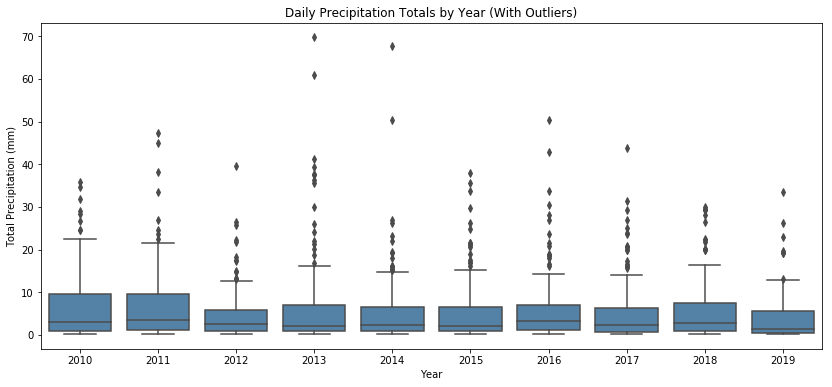

In [156]:
plt.figure(figsize=(14,6))
sns.boxplot(x='year', y='totalPrecipMM', data=rainy_days, color='steelblue').set(
  title='Daily Precipitation Totals by Year (With Outliers)',
  xlabel='Year',
  ylabel='Total Precipitation (mm)'
);

#### Without Outliers

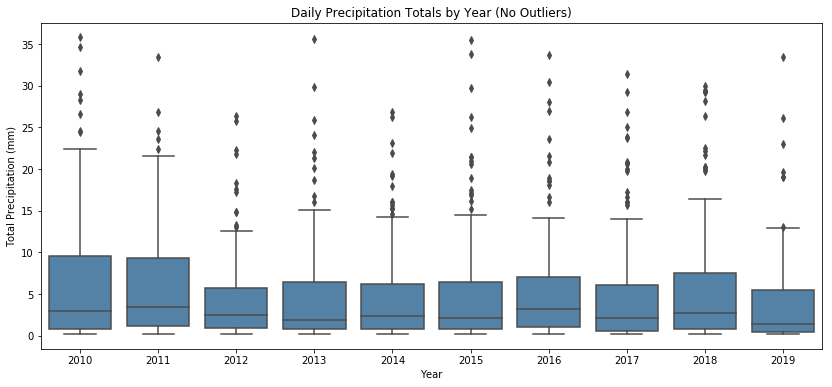

In [157]:
plt.figure(figsize=(14,6))
sns.boxplot(x='year', y='totalPrecipMM', data=rainy_days_no, color='steelblue').set(
  title='Daily Precipitation Totals by Year (No Outliers)',
  xlabel='Year',
  ylabel='Total Precipitation (mm)'
);

Daily precipitation spread (IQR) was larger and the median was higher in 2010, 2011, and 2018 compared to other years. Was it particularly rainy in certain months or throughout the entire year?

In [158]:
rainy_day_stats_by_year = rainy_days_no.groupby(['year'])['totalPrecipMM'].describe()[['50%', 'mean', 'std']]
rainy_day_stats_by_year.style.bar()

,50%,mean,std
year,,,
2010,2.925,6.4875,7.79818
2011,3.45,5.89033,6.27727
2012,2.5,4.24543,5.00687
2013,1.9,4.54486,5.91045
2014,2.4,4.61686,5.50328
2015,2.1,5.16724,7.01913
2016,3.25,5.38354,6.3367
2017,2.175,4.65859,6.1691
2018,2.7,5.47472,6.75284


It's interesting to see that 2017 (a year of extreme precipitation [sources required]) doesn't stand out in terms of daily observed precipitation. Variance appears to be roughly equal.

### By month

#### Without Outliers

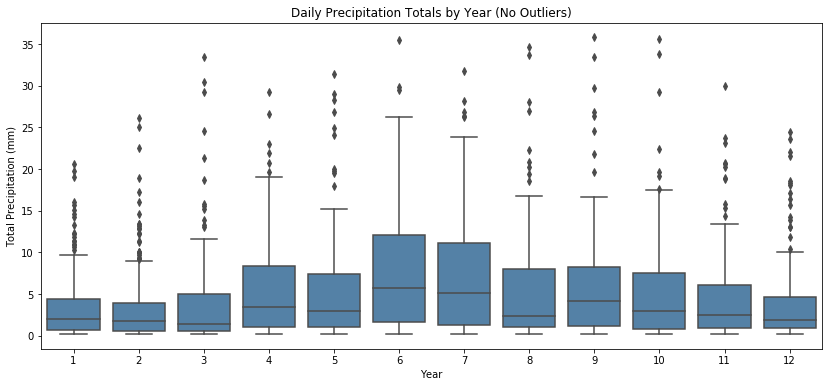

In [159]:
plt.figure(figsize=(14,6))
sns.boxplot(x='month', y='totalPrecipMM', data=rainy_days_no, color='steelblue').set(
  title='Daily Precipitation Totals by Year (No Outliers)',
  xlabel='Year',
  ylabel='Total Precipitation (mm)'
);

In [160]:
rainy_day_stats_by_month = rainy_days_no.groupby(['month']).totalPrecipMM.describe()
rainy_day_stats_by_month.style.bar(subset=['mean', 'std'])

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
1,200,3.45,4.08751,0.2,0.7,2,4.3625,20.65
2,183,3.61311,4.75214,0.2,0.575,1.75,3.95,26.1
3,151,3.9649,5.9027,0.2,0.525,1.4,4.95,33.5
4,146,5.66062,6.00971,0.2,1,3.45,8.375,29.3
5,116,5.85086,7.0604,0.2,1,3,7.425,31.4
6,97,8.45464,8.41649,0.2,1.6,5.7,12.1,35.5
7,92,7.71957,7.74489,0.2,1.275,5.15,11.125,31.8
8,79,6.4519,8.08349,0.2,1,2.4,8,34.7
9,93,6.43118,7.68977,0.2,1.2,4.1,8.2,35.8


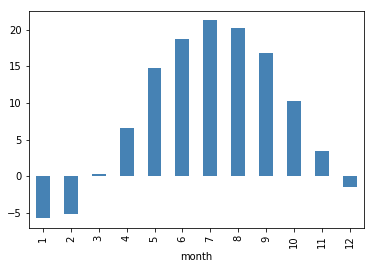

In [161]:
df.groupby('month')['meanTemp'].mean().plot(color='steelblue', kind='bar');

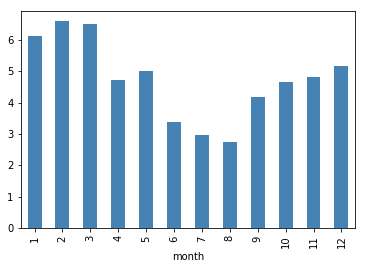

In [162]:
df.groupby('month')['meanTemp'].std().plot(color='steelblue', kind='bar');

* January - March distributions are relatively similar with more extreme observations in February and March
* April - July vary the most
* June appears to have the most erratic precipitation
* August - October ditributions are relatively similar

The most interesting thing to observe here is that is the symmetry of the distribution of the variance of daily precipitation, centered exatly half way through the year (June). 

A possible explanation for the increased variability in June - August is an increase in ground warming, causing more convective precipitation [source].

## How much rain is expected weekly?

We'll include the outliers for the weekly analysis since most of the weekly analysis is concerned with the frequency of rain. Given the low number of outliers, keeping them in this part of the analysis won't have a huge impact in terms of inflating counts.

In [163]:
rainy_days_weekly = (
  rainy_days
    .set_index('date')
    .resample('W-MON', label='left', closed='left')['totalPrecipMM']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'totalPrecipMM', 'count': 'rainyDays'})
    .assign(date=lambda x: pd.to_datetime(x.index))
    .assign(year=lambda x: x.date.dt.year)
    .assign(month=lambda x: x.date.dt.month)
)
rainy_days_weekly.head()

,totalPrecipMM,rainyDays,date,year,month
date,,,,,
2009-12-28,10.10,3,2009-12-28,2009,12
2010-01-04,8.55,4,2010-01-04,2010,1
2010-01-11,1.45,1,2010-01-11,2010,1
2010-01-18,11.60,2,2010-01-18,2010,1
2010-01-25,7.05,6,2010-01-25,2010,1


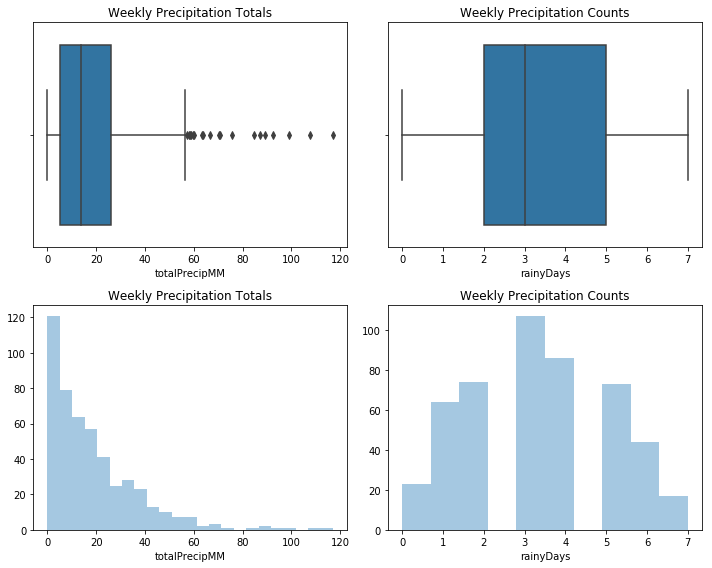

In [164]:
plt.figure(figsize=(10,8))
plt.subplot(221);
sns.boxplot(rainy_days_weekly['totalPrecipMM']).set(title='Weekly Precipitation Totals');
plt.subplot(222);
sns.boxplot(rainy_days_weekly['rainyDays']).set(title='Weekly Precipitation Counts');

plt.subplot(223);
sns.distplot(rainy_days_weekly['totalPrecipMM'], kde=False).set(title='Weekly Precipitation Totals');
plt.subplot(224);
sns.distplot(rainy_days_weekly['rainyDays'], kde=False).set(title='Weekly Precipitation Counts');
plt.tight_layout();

The weekly precipitation total distribution is right skewed and bimodal.

In [165]:
rainy_days_weekly[['rainyDays', 'totalPrecipMM']].describe()

,rainyDays,totalPrecipMM
count,488.000000,488.000000
mean,3.329918,18.413012
std,1.772412,18.035128
min,0.000000,0.000000
25%,2.000000,5.287500
50%,3.000000,13.600000
75%,5.000000,26.012500
max,7.000000,117.100000


Counts appear to be binomially distributed but we should test for it in a follow-up analysis.

## How much rain is expected monthly?

In [166]:
rainy_days_monthly = (
  rainy_days_no
    .set_index('date')
    .resample('1M')['totalPrecipMM']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'totalPrecipMM', 'count': 'rainyDays'})
    .assign(date=lambda x: pd.to_datetime(x.index))
    .assign(year=lambda x: x.date.dt.year)
    .assign(month=lambda x: x.date.dt.month)
)
rainy_days_monthly.head()

,totalPrecipMM,rainyDays,date,year,month
date,,,,,
2010-01-31,38.75,16,2010-01-31,2010,1
2010-02-28,33.45,13,2010-02-28,2010,2
2010-03-31,34.65,7,2010-03-31,2010,3
2010-04-30,76.80,10,2010-04-30,2010,4
2010-05-31,114.20,11,2010-05-31,2010,5


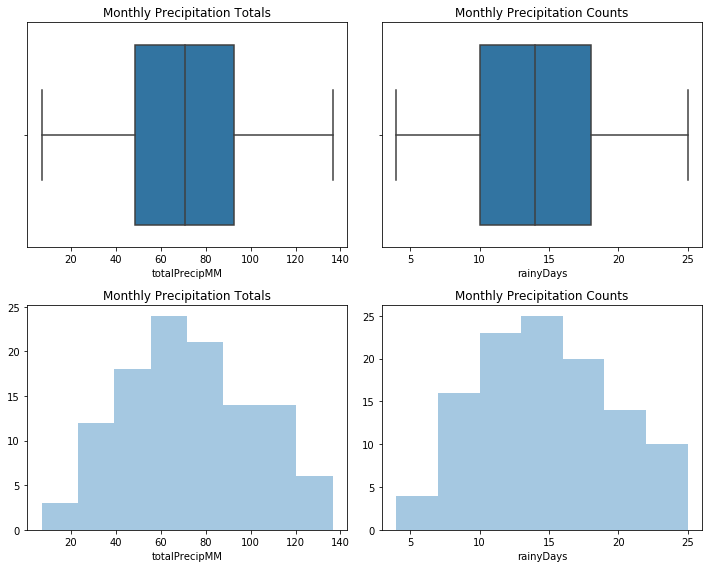

In [167]:
plt.figure(figsize=(10,8))
plt.subplot(221);
sns.boxplot(rainy_days_monthly['totalPrecipMM']).set(title='Monthly Precipitation Totals');
plt.subplot(222);
sns.boxplot(rainy_days_monthly['rainyDays']).set(title='Monthly Precipitation Counts');

plt.subplot(223);
sns.distplot(rainy_days_monthly['totalPrecipMM'], kde=False).set(title='Monthly Precipitation Totals');
plt.subplot(224);
sns.distplot(rainy_days_monthly['rainyDays'], kde=False).set(title='Monthly Precipitation Counts');
plt.tight_layout();

The distributions are more normal at the monthly level and occurances are bimodal which are likely due to seasonality.

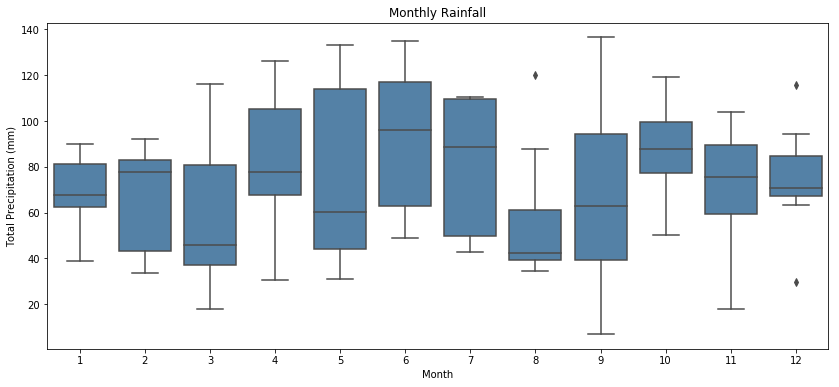

In [168]:
plt.figure(figsize=(14,6))
sns.boxplot(x=rainy_days_monthly['month'], y=rainy_days_monthly['totalPrecipMM'], color='steelblue').set(
  title='Monthly Rainfall',
  xlabel='Month',
  ylabel='Total Precipitation (mm)'
);

We have definitely seen more rain on same days than in entire months. 

In [169]:
rainy_day_stats_by_month = rainy_days_monthly.groupby(['month'])['totalPrecipMM'].describe()[['50%', 'mean', 'std']]
rainy_day_stats_by_month['median_to_mean'] = rainy_day_stats_by_month['50%']/ rainy_day_stats_by_month['mean']
rainy_day_stats_by_month['cov'] = rainy_day_stats_by_month['std'] / rainy_day_stats_by_month['mean']
rainy_day_stats_by_month.sort_values('std').style.bar()

,50%,mean,std,median_to_mean,cov
month,,,,,
1,67.55,69,15.4651,0.978986,0.224132
10,87.9,88.7333,23.0656,0.990609,0.259943
2,77.875,66.12,23.2731,1.17778,0.351983
12,70.95,74.95,23.5228,0.946631,0.313846
11,75.45,70.35,25.2746,1.07249,0.35927
4,77.775,82.645,28.0506,0.941073,0.33941
7,88.7,78.9111,28.9029,1.12405,0.366272
8,42.4,56.6333,28.9338,0.748676,0.510898
6,96.2,91.1222,32.2718,1.05572,0.35416


## How often does it rain?

In [170]:
today = datetime.now().date()
year, month, day = today.year, today.month, today.day

### By year

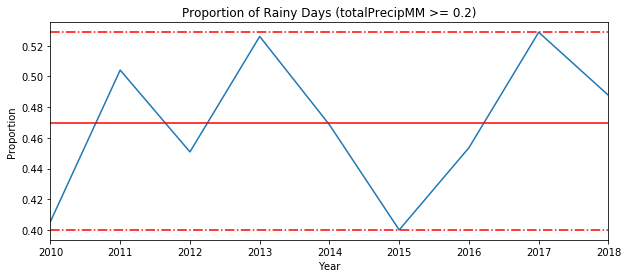

In [171]:
precip_props_by_month = (rainy_days.query(f'year < {year}').groupby('year').size() / df.query(f'year < {year}').groupby('year').size())
precip_props_by_month.plot(figsize=(10,4)).set(
  title='Proportion of Rainy Days (totalPrecipMM >= 0.2)',
  xlabel='Year',
  ylabel='Proportion'
);
plt.axhline(precip_props_by_month.mean(), color='red', linestyle='-');
plt.axhline(precip_props_by_month.min(), color='red', linestyle='-.');
plt.axhline(precip_props_by_month.max(), color='red', linestyle='-.');

Over the last 10 years, 2015 has seen the lowest number / proportion of rainy days and 2017 has seen the most. This wasn't hard to miss [needs sources].

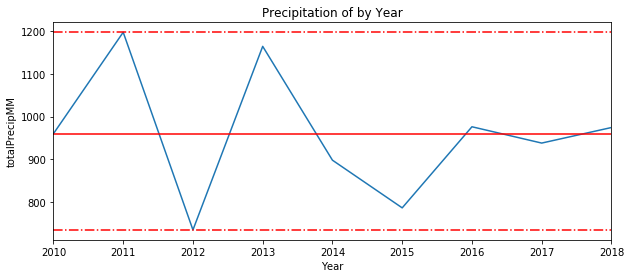

In [172]:
precip_by_month = rainy_days.query(f'year < {year}').groupby('year')['totalPrecipMM'].sum()
precip_by_month.plot(figsize=(10,4)).set(
  title='Precipitation of by Year',
  xlabel='Year',
  ylabel='totalPrecipMM'
);
plt.axhline(precip_by_month.mean(), color='red', linestyle='-');
plt.axhline(precip_by_month.min(), color='red', linestyle='-.');
plt.axhline(precip_by_month.max(), color='red', linestyle='-.');

We have seen the lowest amount of rain in the last several years but we have seen some of the most frequent rain events.

### By year (YTD)

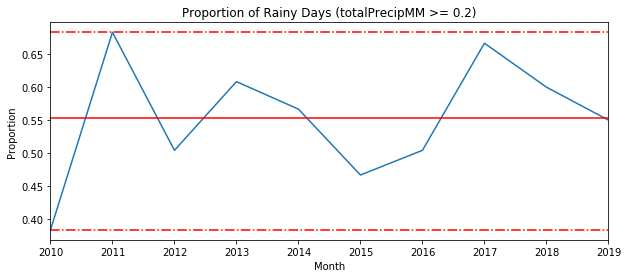

In [173]:
precip_props_by_year = (rainy_days.query(f'month <= {month} & day <= {day}').groupby('year').size() / df.query(f'month < {month}').groupby('year').size())
precip_props_by_year.plot(figsize=(10,4)).set(
  title='Proportion of Rainy Days (totalPrecipMM >= 0.2)',
  xlabel='Month',
  ylabel='Proportion'
);
plt.axhline(precip_props_by_year.mean(), color='red', linestyle='-');
plt.axhline(precip_props_by_year.min(), color='red', linestyle='-.');
plt.axhline(precip_props_by_year.max(), color='red', linestyle='-.');

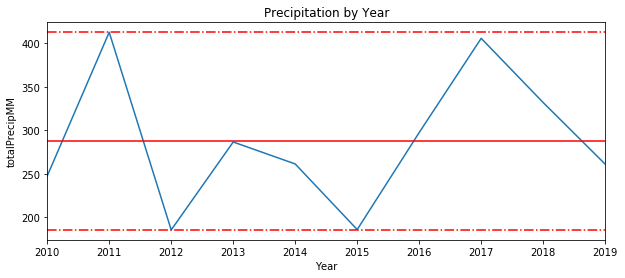

In [174]:
precip_by_year = rainy_days.query(f'month <= {month} & day <= {day}').groupby('year')['totalPrecipMM'].sum()
precip_by_year.plot(figsize=(10,4)).set(
  title='Precipitation by Year',
  xlabel='Year',
  ylabel='totalPrecipMM'
);
plt.axhline(precip_by_year.mean(), color='red', linestyle='-');
plt.axhline(precip_by_year.min(), color='red', linestyle='-.');
plt.axhline(precip_by_year.max(), color='red', linestyle='-.');

### By month

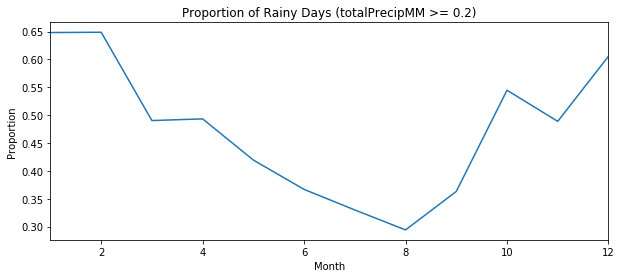

In [57]:
precip_props_by_month = (rainy_days.groupby('month').size() / df.groupby('month').size())
precip_props_by_month.plot(figsize=(10,4)).set(
  title='Proportion of Rainy Days (totalPrecipMM >= 0.2)',
  xlabel='Month',
  ylabel='Proportion'
);

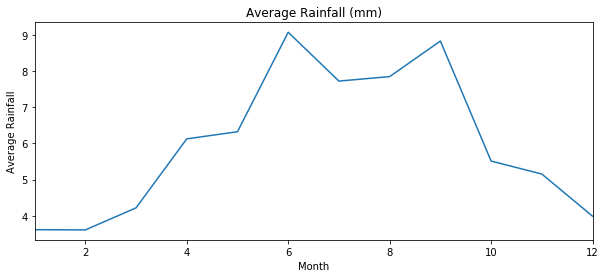

In [74]:
precip_by_month = rainy_days.groupby('month').totalPrecipMM.mean()
precip_by_month.plot(figsize=(10,4)).set(
  title='Average Rainfall (mm)',
  xlabel='Month',
  ylabel='Average Rainfall'
);

It rains less frequently in the summer, but we tend to get more rain.

## Can we discern rainy days from snowy days?

Rainy days in winter months are likely precipitation measurements from snowfall. We can heuristically remove days with both snow and rain, providing snow measurements are not significantly missing for winter months.

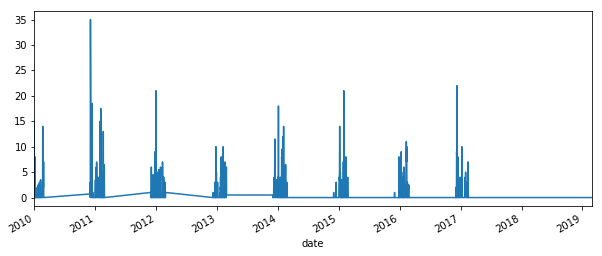

In [59]:
df.set_index('date').query('(season == "winter")')['totalSnowCM'].fillna(0).plot(figsize=(10,4));

We are missing snowfall data after 2017. How does snowfall correlate with precipitation in winter months?

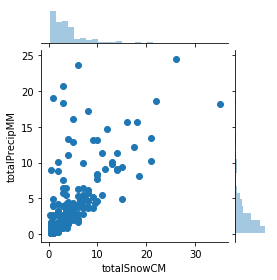

In [60]:
winter_rainy_days = rainy_days.query('(season=="winter") & (date < "2018-01-01") & (totalSnowCM > 0)')
sns.jointplot(
  x="totalSnowCM", y="totalPrecipMM", 
  data=winter_rainy_days, size=4);

It's likely that we would observe days with larger precipitation than snowfall values since (1) it can rain and snow in a day and (2) precipitation may be disproportionate to snowfall depending on the density of the snow and the temperature. If it's hotter out, snow will melt leading to higher precipitation values.

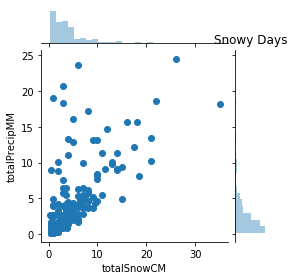

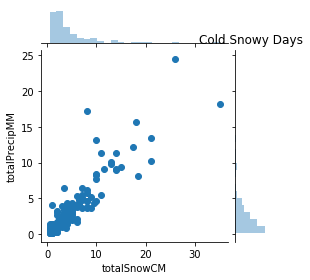

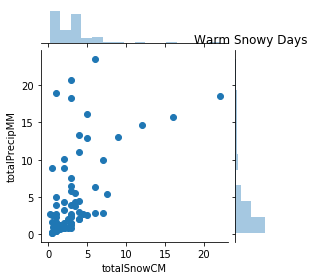

In [61]:
winter_rainy_days = rainy_days.query('(season=="winter") & (date < "2018-01-01")')

snowy_days = winter_rainy_days.query('totalSnowCM > 0')
snowy_cold_days = snowy_days.query('maxTemp < 0')
snowy_warm_days = snowy_days.query('maxTemp > 0')

sns.jointplot(
  x="totalSnowCM", y="totalPrecipMM", 
  data=snowy_days, size=4)
plt.title('Snowy Days')

sns.jointplot(
  x="totalSnowCM", y="totalPrecipMM", 
  data=snowy_cold_days, size=4);
plt.title('Cold Snowy Days')

sns.jointplot(
  x="totalSnowCM", y="totalPrecipMM", 
  data=snowy_warm_days, size=4);
plt.title('Warm Snowy Days');

In [62]:
snowy_days[['totalSnowCM', 'totalPrecipMM']].corr(method='spearman')

,totalSnowCM,totalPrecipMM
totalSnowCM,1.000000,0.778524
totalPrecipMM,0.778524,1.000000


In [63]:
snowy_cold_days[['totalSnowCM', 'totalPrecipMM']].corr(method='spearman')

,totalSnowCM,totalPrecipMM
totalSnowCM,1.000000,0.897205
totalPrecipMM,0.897205,1.000000


In [64]:
snowy_warm_days[['totalSnowCM', 'totalPrecipMM']].corr(method='spearman')

,totalSnowCM,totalPrecipMM
totalSnowCM,1.00000,0.57995
totalPrecipMM,0.57995,1.00000


Disproportionately larger precipitation values, when compared to snow values, could be caused by precipitation in addition to rain (in the case of days with an observed high above zero degrees celsius) or "wetter" snow (see [4]). Rather than come up with methods for predicting snow vs. rain, can simply exclude winter (or rather days with observed lows below zero) from our modelling.

## How many times in a week does it rain?

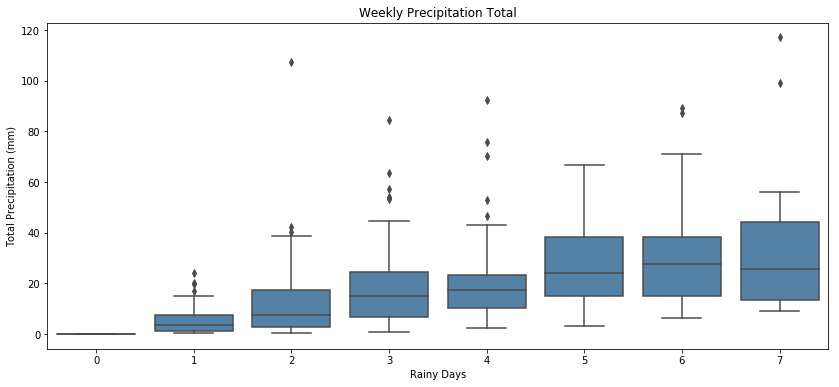

In [65]:
plt.figure(figsize=(14,6))
sns.boxplot(x=rainy_days_weekly['rainyDays'], y=rainy_days_weekly['totalPrecipMM'], color='steelblue').set(
  title='Weekly Precipitation Total',
  xlabel='Rainy Days',
  ylabel='Total Precipitation (mm)'
);

There is generally more variance in precipitation over more observed rainy days which makes sense as more rain events does not necessarily mean that there was more precipitation. It's interesting to see that in one week with two rain events, more than ~110mm of rain was observed - more than 55mm per day.

In [66]:
rainy_days_weekly.query('totalPrecipMM > 100')

,totalPrecipMM,rainyDays,date,year,month
date,,,,,
2010-05-31,117.1,7,2010-05-31,2010,5
2013-09-16,107.4,2,2013-09-16,2013,9


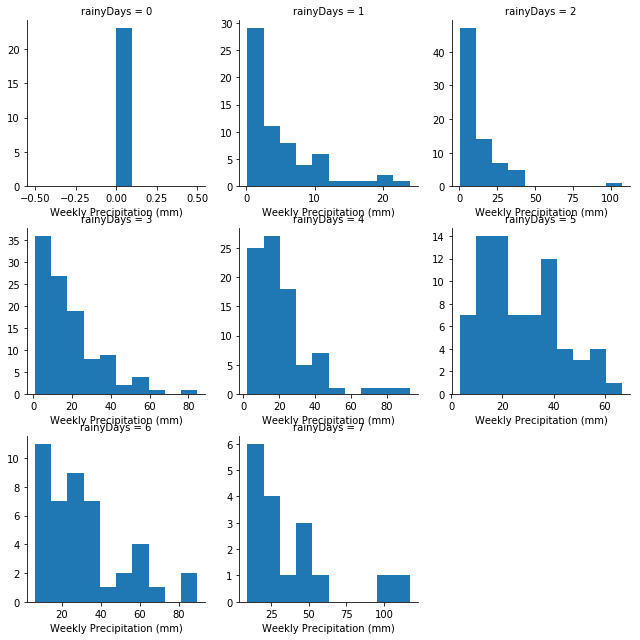

In [114]:
g = sns.FacetGrid(rainy_days_weekly, col='rainyDays', col_wrap=3, sharex=False, sharey=False)
g = g.map(plt.hist, 'totalPrecipMM').set(xlabel='Weekly Precipitation (mm)');

In [117]:
rainy_days_weekly.groupby('rainyDays')['totalPrecipMM'].describe()[['50%', 'mean', 'std', 'max']].style.bar()

,50%,mean,std,max
rainyDays,,,,
0,0,0,0,0
1,3.5,5.18984,5.47025,23.9
2,7.4,12.4453,15.5532,107.4
3,15.1,18.6664,15.5644,84.6
4,17.25,20.414,15.9506,92.6
5,24.2,27.1945,15.3369,66.8
6,27.6,31.3795,21.1008,89.25
7,25.6,36.0971,30.7776,117.1


We typically see a lot more rain in 3 or 4 weekly rain events than in 1 or 2 weekly events and typically see a lot more rain in 5-7 weekly rain events than in 3-4 weekly events.

Without outliers

In [118]:
rainy_day_stats = rainy_days_weekly['totalPrecipMM'].describe()
rainy_day_stats_upper = rainy_day_stats['75%'] + 1.5 * (rainy_day_stats['75%'] - rainy_day_stats['25%'])
print('Outlier threshold:', rainy_day_stats_upper)

Outlier threshold: 57.1


In [119]:
rainy_days_weekly_no = rainy_days_weekly.query('totalPrecipMM < {}'.format(rainy_day_stats_upper))
rainy_days_weekly_no.groupby('rainyDays')['totalPrecipMM'].describe()[['50%', 'mean', 'std', 'max']].style.bar()

,50%,mean,std,max
rainyDays,,,,
0,0,0,0,0
1,3.5,5.18984,5.47025,23.9
2,7,11.1445,10.8774,42.1
3,15,17.2317,13.0835,54
4,16.8,18.2795,11.3222,53.1
5,22.825,25.7207,13.8285,55.5
6,24.1,24.123,12.7261,55.3
7,23.95,26.5033,15.2534,56.25


Typical precipitation is consistent accross 5-7 rainy days and we don't see more than 56mm of rain, excluding outliers.

### Extreme events
Extreme rain events with weeks with an observed precipitation level that is greater than 1.5x the IQR (75th - 25th percentile).

In [120]:
rainy_days_weekly_o = rainy_days_weekly.query('totalPrecipMM >= {}'.format(rainy_day_stats_upper))
rainy_days_weekly_o.groupby('rainyDays').size().sort_values(ascending=False)

rainyDays
6    7
5    3
4    3
3    3
7    2
2    1
dtype: int64

There has never been an extreme rain event where it rained only one day in a week. So any single-day rain event with observed precipitation greater than the threshold would have occurred in a week during which it rained more than once.

In [121]:
outliers = (
  rainy_days_weekly_o
    .assign(date=lambda x: pd.to_datetime(x.index))
    .assign(year=lambda x: x.date.dt.year)
    .assign(month=lambda x: x.date.dt.month)
)
outliers.groupby(['year', 'month']).size()

year  month
2010  4        1
      5        1
2011  11       1
2013  1        1
      4        1
      5        1
      9        2
2014  9        2
2015  6        2
2016  3        1
      8        2
2017  5        1
2018  6        1
      10       1
2019  4        1
dtype: int64

Aside from 2013, extreme weekly rain events happen 1-2 times per year.

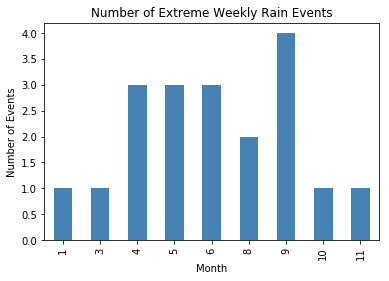

In [122]:
outliers.groupby('month').size().plot(kind='bar', color='steelblue').set(
  title='Number of Extreme Weekly Rain Events',
  xlabel='Month',
  ylabel='Number of Events'
);

May and June are associated the highest number of extreme weekly rain events.

### By week and year

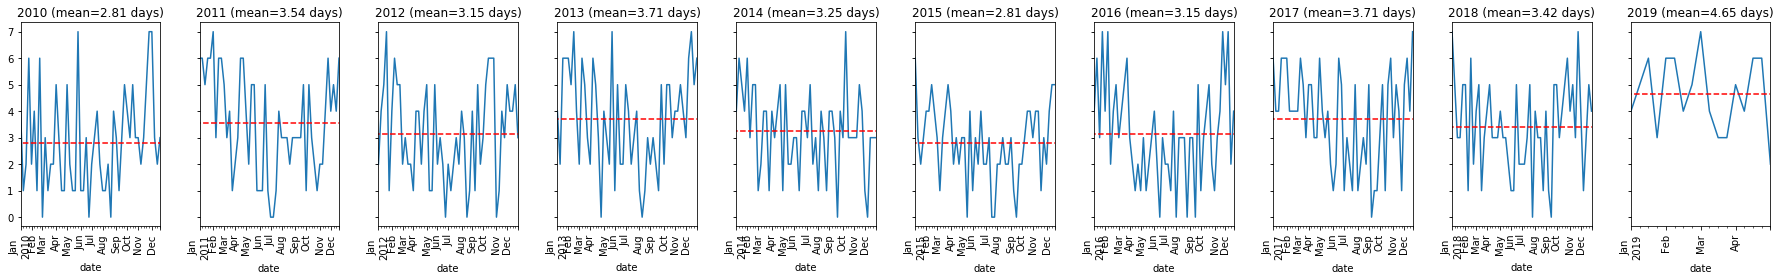

In [123]:
fig, ax = plt.subplots(1, 10, sharey=True, figsize=(25,4))
month = datetime.today().month
for i, y in enumerate(range(2010, 2020)):
  d = rainy_days_weekly.query("(year == {})".format(y))['rainyDays']
  _ = d.plot(ax=ax[i], rot=90)
  _.axhline(y=d.mean(), xmin=-1, xmax=1, c="red", linewidth=1.5, linestyle="--")
  _.set_title("{} (mean={:.2f} days)".format(y, d.mean()))
plt.tight_layout();

### Weekly average by year and month

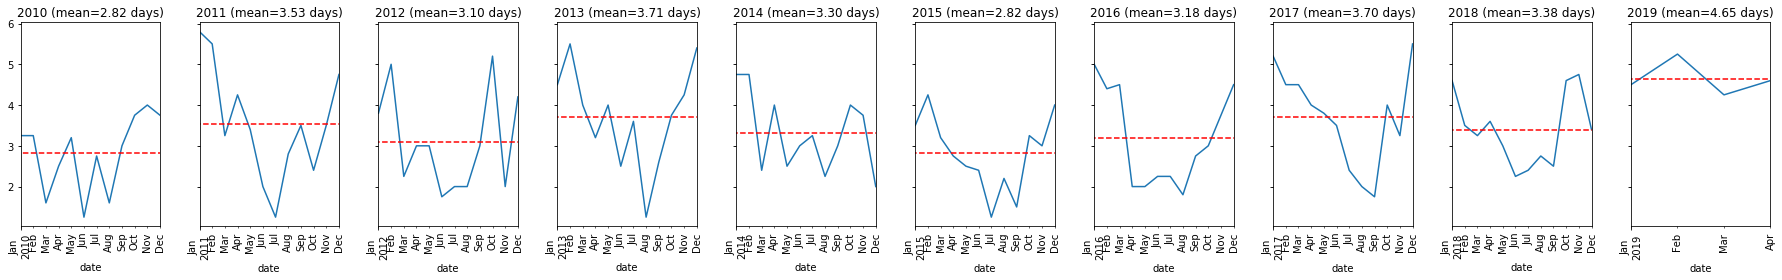

In [75]:
fig, ax = plt.subplots(1, 10, sharey=True, figsize=(25,4))
month = datetime.today().month
for i, y in enumerate(range(2010, 2020)):
  d = rainy_days_weekly.query("(year == {})".format(y)).resample('1M')['rainyDays'].mean()
  _ = d.plot(ax=ax[i], rot=90)
  _.axhline(y=d.mean(), xmin=-1, xmax=1, c="red", linewidth=1.5, linestyle="--")
  _.set_title("{} (mean={:.2f} days)".format(y, d.mean()))
plt.tight_layout();

While there are some years with exceptions, both the weekly and average weekly rain day counts appear U-shaped, exhibiting seasonality that aligns with the rain distributions.

### Weekly average by month and year

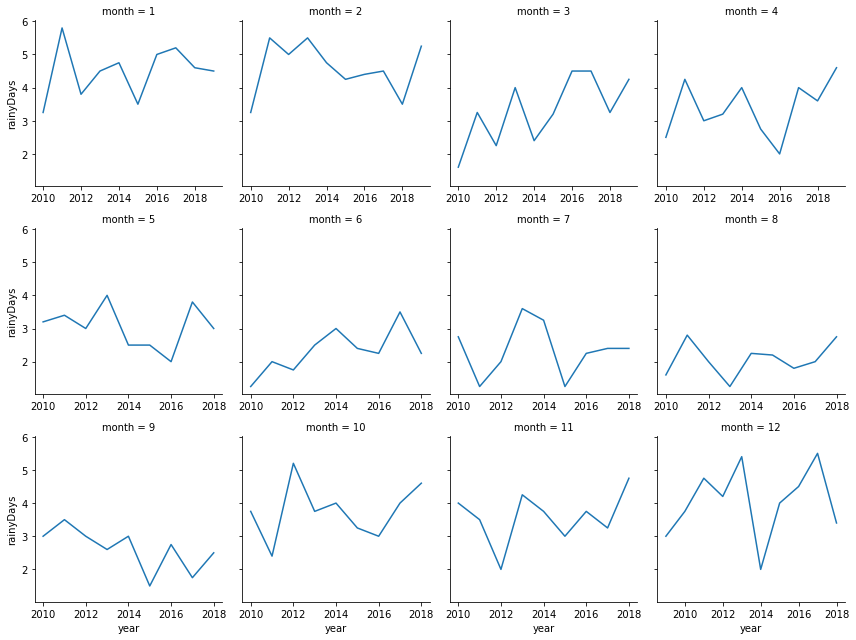

In [76]:
weekly_rainy_day_counts = rainy_days_weekly.groupby(['year', 'month'])['rainyDays'].mean().reset_index()
g = sns.FacetGrid(weekly_rainy_day_counts, col='month', col_wrap=4, sharex=False)
g = g.map(plt.plot, 'year', 'rainyDays');

We've seen a general upward trend in weekly rainy events in March, April, June, August, and November with the highest April average in the last ten years.

[1] https://ec.gc.ca/meteo-weather/default.asp?lang=En&n=B8CD636F-1&def=show02B55773D#wsDT2B55773D

[1] http://glossary.ametsoc.org/wiki/Rain

[2] http://climate.weather.gc.ca/historical_data/search_historic_data_stations_e.html?searchType=stnName&timeframe=1&txtStationName=London&searchMethod=contains&optLimit=yearRange&StartYear=1840&EndYear=2019&Year=2019&Month=2&Day=22&selRowPerPage=25

[3] https://www.int-res.com/articles/cr_oa/c067p071.pdf

[4] http://www.theweatherprediction.com/habyhints2/650/

#### NOTES
* Normals available at http://climate.weather.gc.ca/climate_normals/results_1981_2010_e.html?stnID=4789&autofwd=1